In [1]:
import sys
sys.path.append('/home/nigitha/ros2_ws_rnd/src')

In [2]:
import rosbag2_py
import numpy as np
import rclpy
from rclpy.node import Node
from nav_msgs.msg import OccupancyGrid, Path
from rclpy.serialization import deserialize_message
import os
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

from Evaluation.Astar import AStarPlanner

In [3]:
class ExtractPath():
    def __init__(self, bag_file):
        
        self.bag_file = bag_file       

        # Containers for data
        self.path = None
        self.map = None
        self.map_resolution = None
        self.map_origin = None

        # Process messages
        self.process_bag(bag_file)

    def process_bag(self, bag_file):
        reader = rosbag2_py.SequentialReader()
        storage_options = rosbag2_py.StorageOptions(uri=bag_file, storage_id='sqlite3')
        converter_options = rosbag2_py.ConverterOptions(input_serialization_format='cdr', output_serialization_format='cdr')        
        reader.open(storage_options, converter_options)
        while reader.has_next():
            topic, msg, t = reader.read_next()

            if topic == "/robot_path":
                self.process_path(msg, t)
            elif topic == "/map":
                self.process_map(msg, t)

    def process_path(self, msg, timestamp):
        path_msg = deserialize_message(msg, Path)
        self.path = path_msg

    def process_map(self, msg, timestamp):
        map_msg = deserialize_message(msg, OccupancyGrid)
        # Extract metadata
        self.map_resolution = map_msg.info.resolution
        width = map_msg.info.width
        height = map_msg.info.height
        self.map_origin = [map_msg.info.origin.position.x, map_msg.info.origin.position.y]

        # Extract the occupancy data
        self.map = np.array(map_msg.data).reshape((height, width))
        
    


In [4]:
def extract_coordinates(path_msg):
    """Extract X, Y coordinates from the path message."""    
    x_coords = []
    y_coords = []
    for pose in path_msg.poses:
        x_coords.append(pose.pose.position.x)
        y_coords.append(pose.pose.position.y)
    
    return np.array(x_coords), np.array(y_coords)

In [5]:
def transform_paths_to_same_start(paths):
    # Get the start point of the first path
    first_path_start_x = paths[0]['path'][0][0]  # Assuming paths are in a list of tuples: (x_coords, y_coords)
    first_path_start_y = paths[0]['path'][1][1]
    
    # Apply transformation to all paths
    for i, path in paths.items():
        # Calculate translation needed to align the start point with the first path's start
        translation_x = first_path_start_x - path['path'][0][0]  # Difference in x
        translation_y = first_path_start_y - path['path'][1][0]  # Difference in y

        # Apply translation to all points in the path
        transformed_x = path['path'][0] + translation_x
        transformed_y = path['path'][1] + translation_y
        
        # Store the transformed path
        paths[i]['path'] = (transformed_x, transformed_y)
    
    return paths

In [6]:
def mean_goal(paths):
    # Get the start point of the first path
    end_points_x = []
    end_points_y = []
    
    # Apply transformation to all paths
    for i, path in paths.items():        
        end_points_x.append(path['path'][0][-1])
        end_points_y.append(path['path'][1][-1])
    
    goal = np.mean(end_points_x), np.mean(end_points_y)
    
    for i, path in paths.items():        
        paths[i]['goal']=goal
    
    return paths

In [7]:
import os

root_folder = '/home/nigitha/ros2_ws_rnd/src/Imitation_Learning/experiments/exp_bags'
paths = {}
for item in os.listdir(root_folder):
    item_path = os.path.join(root_folder, item)
    if os.path.isdir(item_path):
        output_dir = "/home/nigitha/ros2_ws_rnd/src/Evaluation"  # Replace with your output directory path
        output_dir = os.path.join(output_dir, item)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        paths[item] = {}
            
        file_count = 0
        for file in os.listdir(item_path):
            file_path = os.path.join(item_path, file)
            extractor = ExtractPath(file_path)
            if file_count ==0:
                map_=extractor.map
                map_origin_ = extractor.map_origin
                map_resolution_ = extractor.map_resolution
                
            paths[item][file_count] = {'path': extract_coordinates(extractor.path), 'map':map_, 
                                       'map_origin':map_origin_, 'map_resolution':map_resolution_}           
                
            file_count = file_count+1
            
        paths[item] = transform_paths_to_same_start(paths[item])
        paths[item] = mean_goal(paths[item])
        

[INFO] [1733857298.273730379] [rosbag2_storage]: Opened database '/home/nigitha/ros2_ws_rnd/src/Imitation_Learning/experiments/exp_bags/path02/laser_corr07112024_path02_run02/laser_corr07112024_path02_run02_0.db3' for READ_ONLY.
[INFO] [1733857298.345408636] [rosbag2_storage]: Opened database '/home/nigitha/ros2_ws_rnd/src/Imitation_Learning/experiments/exp_bags/path02/laser_corr07112024_path02_run04/laser_corr07112024_path02_run04_0.db3' for READ_ONLY.
[INFO] [1733857298.359902207] [rosbag2_storage]: Opened database '/home/nigitha/ros2_ws_rnd/src/Imitation_Learning/experiments/exp_bags/path02/laser_corr07112024_path02_run05/laser_corr07112024_path02_run05_0.db3' for READ_ONLY.
[INFO] [1733857298.372348595] [rosbag2_storage]: Opened database '/home/nigitha/ros2_ws_rnd/src/Imitation_Learning/experiments/exp_bags/path02/laser_corr07112024_path02_run03/laser_corr07112024_path02_run03_0.db3' for READ_ONLY.
[INFO] [1733857298.558380526] [rosbag2_storage]: Opened database '/home/nigitha/ros2

In [41]:
import numpy as np

def extend_map_to_include_points(run_detail):
    
    start = (run_detail['path'][0][0],run_detail['path'][1][0])
    map_origin = run_detail['map_origin']
    map_resolution = run_detail['map_resolution']
    map_data = run_detail['map']
    goal = run_detail['goal']

    # Determine the current bounds of the map
    map_height, map_width = map_data.shape
    map_x_min = map_origin[0]
    map_x_max = map_origin[0] + map_width * map_resolution
    map_y_min = map_origin[1]
    map_y_max = map_origin[1] + map_height * map_resolution
    # Determine the required bounds to include the points
    points = np.array([start, goal])
    x_min = min(map_x_min, points[:, 0].min())-0.1
    x_max = max(map_x_max, points[:, 0].max())+0.1
    y_min = min(map_y_min, points[:, 1].min())-0.1
    y_max = max(map_y_max, points[:, 1].max())+0.1

    # Calculate the required size of the new map
    new_width = int(np.ceil((x_max - x_min) / map_resolution))
    new_height = int(np.ceil((y_max - y_min) / map_resolution))
    # Create a new map with the required size, filled with default values (e.g., obstacle)
    extended_map = np.full((new_height, new_width), fill_value=0, dtype=map_data.dtype)  # 1 for obstacle
    # Calculate the offsets for placing the old map in the new map
    x_offset = int((map_origin[0] - x_min) / map_resolution)
    y_offset = int((map_origin[1] - y_min) / map_resolution)

    # Place the old map into the new map
    extended_map[y_offset:y_offset + map_height, x_offset:x_offset + map_width] = map_data

    # Update the map origin
    new_map_origin = (x_min, y_min)

    return extended_map, new_map_origin


In [42]:
def smooth_grid(grid, kernel_size=5):
    """
    Applies a moving average filter to smooth the grid.
    """
    # Create an empty grid of the same shape
    smoothed_grid = np.zeros_like(grid)
    
    # Apply the moving average filter
    for i in range(1, grid.shape[0] - 1):
        for j in range(1, grid.shape[1] - 1):
            # Get the neighbors (including diagonals)
            neighbors = grid[i-1:i+2, j-1:j+2]
            smoothed_grid[i, j] = np.mean(neighbors)
    
    # Threshold the smoothed grid to make it binary again (0 for free, 1 for obstacle)
    smoothed_grid = np.where(smoothed_grid < 50, 0, 100)
    
    return smoothed_grid

In [43]:
from scipy.interpolate import interp1d
from skimage.graph import route_through_array

    
def calculate_ideal_path_with_map(run_detail):
    start = (run_detail['path'][0][0],run_detail['path'][1][0])
    map_origin = run_detail['map_origin']
    map_resolution = run_detail['map_resolution']
    map_data = run_detail['map']
    goal = run_detail['goal']
    map_data, map_origin = extend_map_to_include_points(
        run_detail
    )
    
    
    # Convert start and goal to pixel coordinates
    start_px = (
        int((start[0] - map_origin[0]) / map_resolution),
        int((start[1] - map_origin[1]) / map_resolution),
    )
    goal_px = (
        int((goal[0] - map_origin[0]) / map_resolution),
        int((goal[1] - map_origin[1]) / map_resolution),
    )
    # Ensure points are within the map boundaries
    if not (0 <= start_px[0] < map_data.shape[1] and 0 <= start_px[1] < map_data.shape[0]):
        raise ValueError("Start point is out of map bounds.")
    if not (0 <= goal_px[0] < map_data.shape[1] and 0 <= goal_px[1] < map_data.shape[0]):
        raise ValueError("Goal point is out of map bounds.")
    print(start_px,   goal_px)
    map_data = smooth_grid(map_data)
    
    
    planner = AStarPlanner(np.zeros_like(map_data))
    path_indices = np.array(planner.a_star_search(start_px, goal_px))
    # Convert pixel coordinates back to world coordinates
    ideal_path = np.zeros_like(path_indices, dtype=float)
    ideal_path[:, 0] = path_indices[:, 0] * map_resolution + map_origin[0]
    ideal_path[:, 1] = path_indices[:, 1] * map_resolution + map_origin[1]
    return ideal_path, map_data, map_origin, map_resolution


In [47]:
import matplotlib.pyplot as plt
import numpy as np


def transform_path_to_map_pixel(path, map_origin, new_resolution):
    # Transform path coordinates to map pixel indices based on the new resolution
    map_x = (path[0] - map_origin[0]) / new_resolution
    map_y = (path[1] - map_origin[1]) / new_resolution
    
    # Convert to pixel indices
    map_x = map_x.astype(int)
    map_y = map_y.astype(int)
    return map_x, map_y

def plot_multiple_paths_on_map(path_details_dict, resolution_factor=3):
    """
    Plots multiple robot paths on the map after increasing the map resolution (upsampling).
    
    Parameters:
    - path_details_dict: A dictionary where each key corresponds to a path's details, which include:
      - 'path': A tuple of (x_coords, y_coords) for the path.
      - 'map': The map data.
      - 'map_resolution': The map's resolution.
      - 'map_origin': The map's origin coordinates (x, y).
    - resolution_factor: The factor by which to increase the map resolution (default is 2).
    """
    # Create a figure for plotting
    plt.figure(figsize=(20, 10))
    count = 0
    
    for run_name, path_details in path_details_dict.items():
        # Extract values from the dictionary
        path = path_details['path']
       

        # Mark the start and end points of the path
        if count == 0:
            map_data = path_details['map']
            map_resolution = path_details['map_resolution']
            map_origin = path_details['map_origin']
            goal = path_details['goal']
            
            # ideal_path, map_data, map_origin, map_resolution = calculate_ideal_path_with_map(path_details) 
            map_data, map_origin = extend_map_to_include_points(path_details)        
            map_resolution = map_resolution / resolution_factor  # New resolution is finer
            map_data = zoom(map_data, (resolution_factor, resolution_factor), order=1)
            map_x, map_y = transform_path_to_map_pixel(path, map_origin, map_resolution)
            # map_x, map_y = transform_path_to_map_pixel([ideal_path[:, 0], ideal_path[:, 1]], map_origin, map_resolution)
            # plt.plot(map_x, map_y, linewidth=3, label=f'Ideal Path')
            # Plot the upsampled map data
            plt.imshow(map_data, origin='lower', cmap='gray', interpolation='none')
            goal_x = (goal[0] - map_origin[0]) / map_resolution
            goal_y = (goal[1] - map_origin[1]) / map_resolution
            plt.scatter(map_x[0], map_y[0], color='green', label=f'Start Position', s=60)
            plt.scatter(goal_x, goal_y, color='Red', label=f'Goal Position', s=60)
            
        # Upsample the map by the resolution factor
        map_x, map_y = transform_path_to_map_pixel(path, map_origin, map_resolution)
        

        # Plot the path for this specific path
        plt.plot(map_x, map_y, label=f'Run {run_name} Path')
        plt.scatter(map_x[-1], map_y[-1], label=f'Run {run_name} End', s=20)
        count += 1
    
    # Add labels and title
    plt.xlabel("Map X (pixels)")
    plt.ylabel("Map Y (pixels)")
    plt.title("Multiple Robot Paths on Upsampled Map")
    plt.legend(loc='upper right')
    
    # Display the plot
    plt.show()


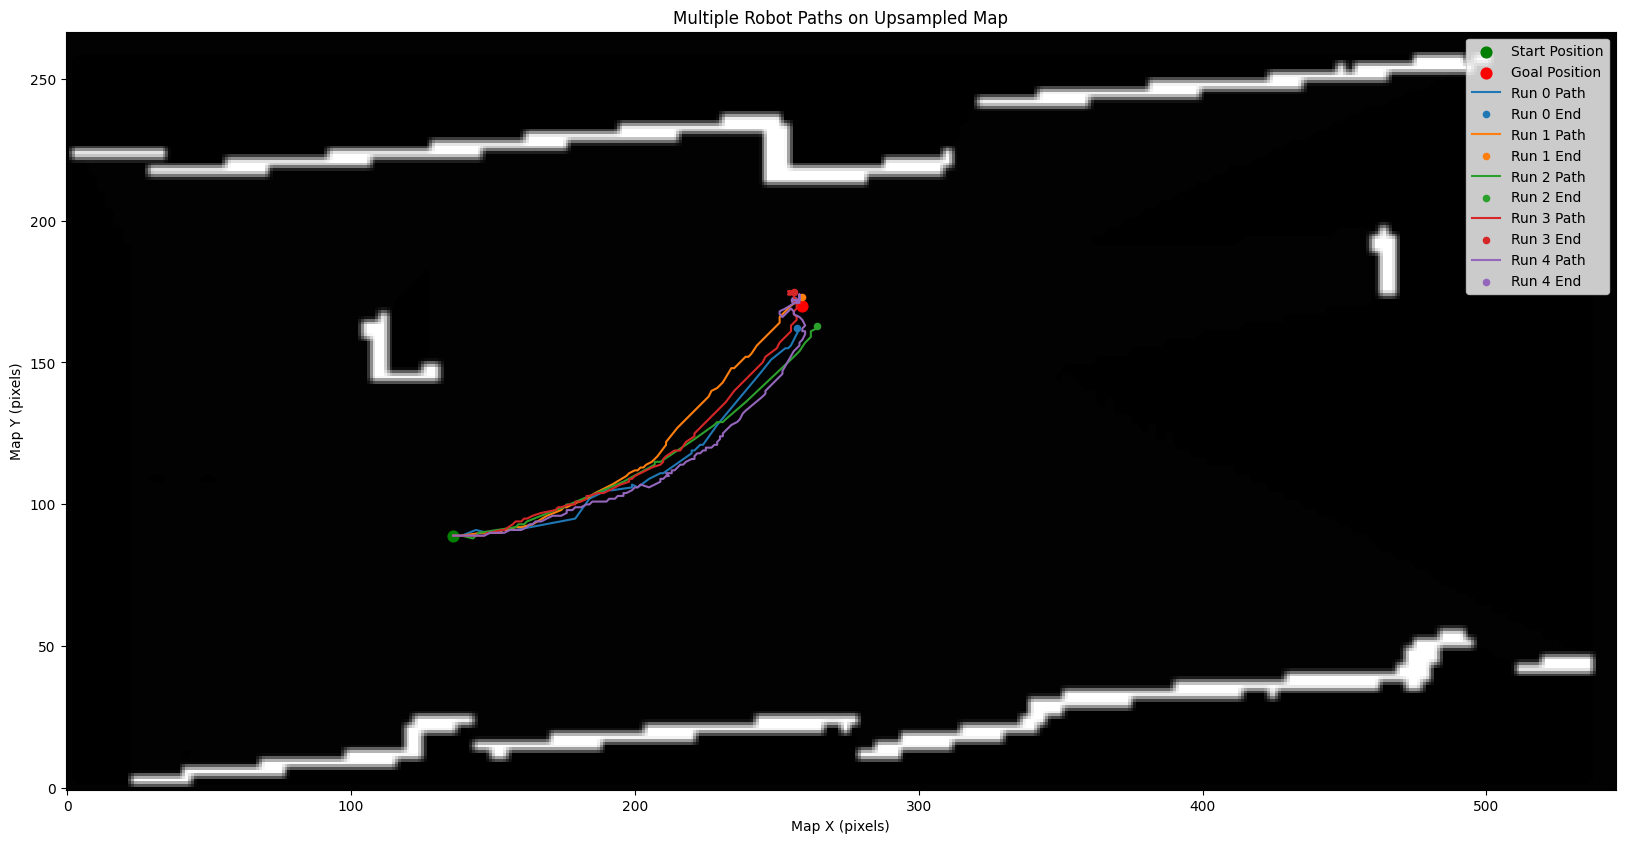

In [48]:
plot_multiple_paths_on_map(paths['path02'])

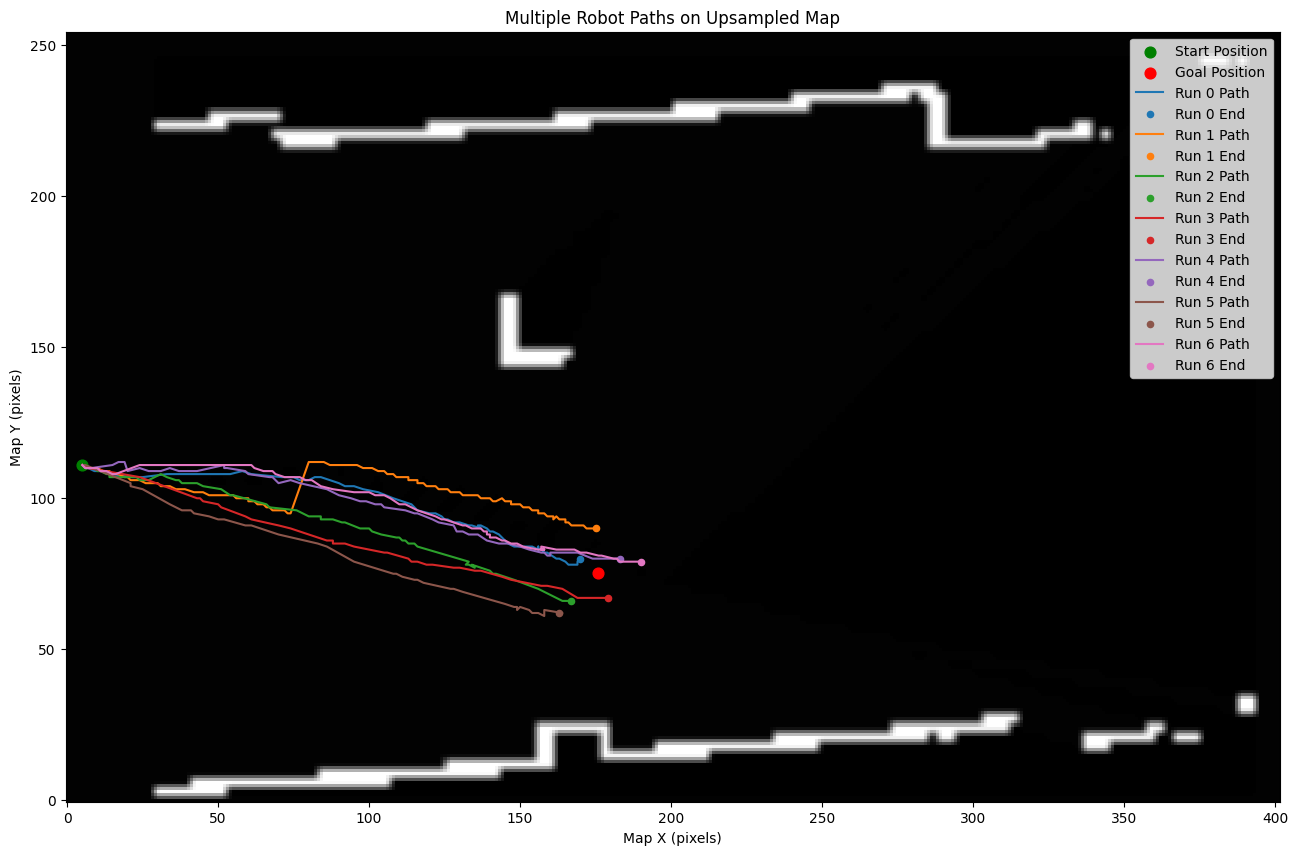

In [49]:
plot_multiple_paths_on_map(paths['path01'])

In [50]:
def get_path_len(path):
    path_length = 0
    for i in range(1, len(path[0])):
        delta = np.linalg.norm(np.array([path[0][i],path[1][i]]) - np.array([path[0][i-1],path[1][i-1]]))
        path_length += delta
    return path_length


In [51]:
def get_dist_from_goal(path, goal):
    return np.linalg.norm([path[0][-1],path[1][-1]]- np.array(goal))

In [66]:
def get_metrics(runs, goal_reach_thresh=0.5):
    
    total_distance_from_goal = 0
    total_path_length= 0
    success_count = 0
    for run_name, run in runs.items(): 
        path =  run['path']     
        final_point = run['path'][-1]
        goal = run['goal']
        path_length = get_path_len(path)
        total_path_length += path_length
        distance_from_goal = get_dist_from_goal(path, goal)        
        total_distance_from_goal += distance_from_goal
        if distance_from_goal < goal_reach_thresh:  # Threshold for success
            success_count += 1
            
        start_to_goal_dist = np.linalg.norm(np.array([path[0][0],path[1][0]]) - np.array(goal))
    num_paths = len(runs)
    metrics = {
        'success_rate': success_count / num_paths,
        'mean_distance_from_goal': total_distance_from_goal / num_paths,
        'mean_path_length': total_path_length / num_paths,
        'start_to_goal_dist': start_to_goal_dist
    }
    print(metrics)
    return metrics

In [67]:
metric_dict = {}
for path_name, path in paths.items():
    metric_dict[path_name]= get_metrics(path)

{'success_rate': 1.0, 'mean_distance_from_goal': 0.09650679829002111, 'mean_path_length': 2.7181095500497725, 'start_to_goal_dist': 2.437987015184155}
{'success_rate': 1.0, 'mean_distance_from_goal': 0.19883899056135743, 'mean_path_length': 3.038932786464391, 'start_to_goal_dist': 2.894642275796268}


In [68]:
final_metrics_df = pd.DataFrame.from_dict(metric_dict, orient='index')

In [69]:
final_metrics_df

,success_rate,mean_distance_from_goal,mean_path_length,start_to_goal_dist
path02,1.0,0.096507,2.718110,2.437987
path01,1.0,0.198839,3.038933,2.894642
